# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [1]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

C:\Users\Kiko-PC\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter
import pandas as pd
import csv

Populating the interactive namespace from numpy and matplotlib


First of all, you have you have to read the data. Run the cell below to unpack data.

In [3]:
from get_data import unpack
unpack('Face_Recognition_data.zip')

### Reading data for image and video classification (1 point)

In [4]:
from os.path import join
train_table = pd.read_csv('Face_Recognition_data/image_classification/train/y_train.csv')

In [5]:
len(train_table)

661

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [6]:
from os.path import join

def load_image_data(dir_name = 'Face_Recognition_data/image_classification'):
    train_labels, test_labels, train_images, test_images = {}, {}, {}, {}
   
    train_df = pd.read_csv(join(dir_name, 'train/y_train.csv'))
    test_df = pd.read_csv(join(dir_name, 'test/y_test.csv'))
    for i in range(len(train_df)):
        row = train_df.iloc[i]
        img = imread(join(dir_name+'/train','images/'+row[0]))   
        train_labels[row[0]]=row[1]
        train_images[row[0]]=img
        
    for i in range(len(test_df)):
        row = test_df.iloc[i]
        img = imread(join(dir_name+'/test','images/'+row[0]))   
        test_labels[row[0]]=row[1]
        test_images[row[0]]=img
    return train_images, train_labels, test_images, test_labels

In [7]:
x_train, y_train, x_test, y_test = load_image_data()

In [8]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

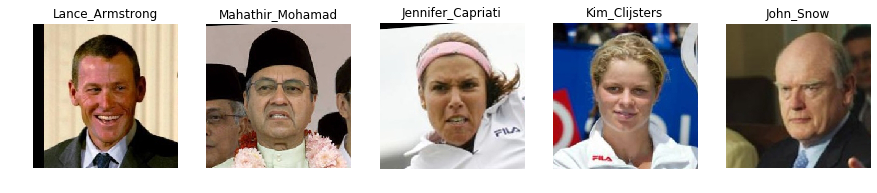

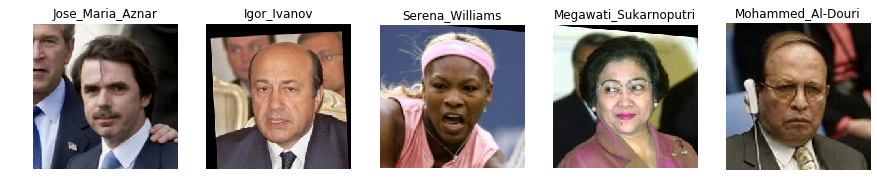

In [9]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [10]:
from os import listdir
def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):
    train_labels, test_labels, train_images, test_images = {}, {}, {}, {}
   
    train_table = pd.read_csv(join(dir_name, 'train/y_train.csv'))
    test_table = pd.read_csv(join(dir_name, 'test/y_test.csv'))
    for i in range(len(train_table)):
        row = train_table.iloc[i]
        img = imread(join(dir_name+'/train','images/'+str(row[0])))   
        train_labels[row[0]]=row[1]
        train_images[row[0]]=img
        
    for i in range(len(test_table)):
        row = test_table.iloc[i]
        img_arr=[]
        video_dir = join(dir_name+'/test','videos/'+str(row[0]))
        for filename in listdir(video_dir):
            img_arr.append(imread(join(video_dir,filename)))  

            test_labels[row[0]]=row[1]
        test_images[row[0]]=img_arr
    return train_images, train_labels, test_images, test_labels

In [11]:
video_train, train_labels, video_test, test_labels = load_video_data()

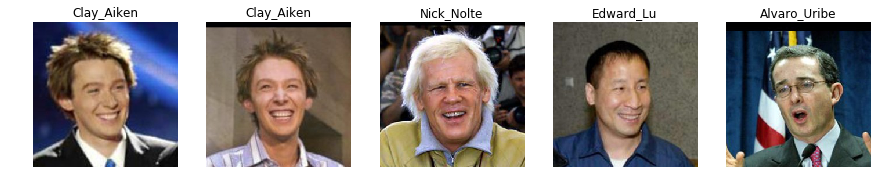

In [12]:
visualize(video_train, train_labels)

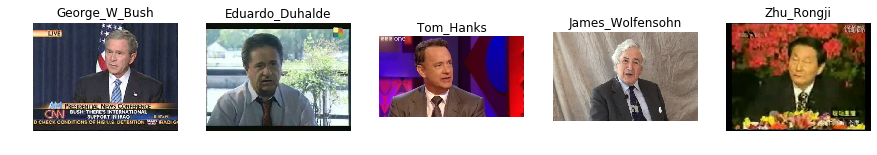

In [13]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

# Big Notice : I am going to solve this problem based on face detection from the previous assignment

In [14]:
SAMPLE_SHAPE = (32, 32, 3)

In [15]:
PATH = 'C:/Users/Kiko-PC/Anaconda3/envs/tensorflow/Lib/site-packages/cv2/data/'
import skimage

from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize

def preprocess_imgs(imgs):
    result = []
    
    face_cascade = cv2.CascadeClassifier(PATH+'haarcascade_frontalface_default.xml')
    
    for img in imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        
        max_face = 0
        chosen_face=None
        for face in faces:
            _,_,w,h = face
            if (w*h > max_face):
                max_face = w*h
                chosen_face = face
           
        try:
            #chosen_face = face[len(faces)/2]
            x,y,w,h = chosen_face
            img = img[y:y+h, x:x+w]
        except Exception as ex:
            pass
        
      #  print(img.shape)
        result.append(cv2.resize(img, (224,224))/255)

    
    return result

#### Visualization of preprocessing

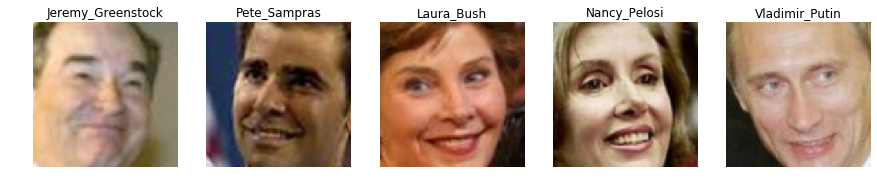

In [16]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])

In [17]:
nubmer_classes = (len(set(y_train.values())))

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [18]:
import h5py
from keras.models import load_model
model = load_model('face_recognition_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [19]:
from sklearn.preprocessing import LabelBinarizer

def get_layer_output(images, layer = 'fc8'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [23]:
import keras
from keras.callbacks import * 
from keras.layers import *
from keras.callbacks import LearningRateScheduler
class Classifier():
    def __init__(self):
        self.nn_model = load_model('face_recognition_model.h5')
        self.one_hot_encoder = LabelBinarizer()

    
    def create_model(self, input_shape=(500,), n_classes=107):
        for layer in  self.nn_model.layers:
            layer.trainable=False
 
        for layer in  self.nn_model.layers[-3:]:
            layer.trainable=True
            
        inputs = self.nn_model.input
        x = self.nn_model.get_layer('fc8').input
        x = Dense(256, activation='relu')(x)
        ans = Dense(n_classes, activation='softmax')(x)
        self.model =  Model(inputs=inputs, outputs=ans)
        self.model.summary()
    
    def get_model(self):
        return self.model
    
    def fit_one_hot_encoding(self, labels):
        to_categorical =  list(set(labels))
        self.one_hot_encoder.fit(to_categorical)
        
    def get_one_hot_encoding(self, label):
        return self.one_hot_encoder.transform(label)
    
    def fit_one_hot_encoding_test(self, labels):
        to_categorical =  list(set(labels))
        self.one_hot_encoder.fit(to_categorical)
        
    def get_one_hot_encoding_test(self, label):
        return self.one_hot_encoder.transform(label)
    

    def fit(self, train_imgs, train_labels, learning_rate=0.001, epochs=15):
        self.fit_one_hot_encoding(train_labels.values())
        self.x_train = np.array(preprocess_imgs(train_imgs.values()))
        self.y_train = np.squeeze(np.array(list(map(lambda x: self.get_one_hot_encoding([x]), train_labels.values()))))
        
      

        
        self.create_model(n_classes=self.y_train.shape[1])
        
#         lrSchedule = lambda i,r : r*1 if i >0 and i%10 == 0 else r
#         lrCallback = [LearningRateScheduler(lrSchedule,1)]
        
              
#         new_callback = [keras.callbacks.EarlyStopping(monitor='val_acc', 
#                                                       min_delta=0,
#                                                       patience=15, 
#                                                       verbose=0, 
#                                                       mode='auto', 
#                                                       baseline=0, 
#                                                       restore_best_weights=True)]

        self.model.compile(loss='categorical_crossentropy', 
                           optimizer=keras.optimizers.Adam(lr=learning_rate), 
                           metrics=['accuracy'])
        #X_train, X_test, y_train, y_test = train_test_split(output_transfer, self.y_train, test_size=0.2, random_state=42)
        self.model.fit(self.x_train, self.y_train,
                       batch_size=32, 
                       epochs=epochs, 
                       shuffle = True,
                       verbose=1)
                       #callbacks = lrCallback+new_callback)

    def classify_images(self, test_imgs):
        X =  np.array(preprocess_imgs(test_imgs.values()))
        y_pred = self.model.predict(X)
        
        classes = np.argmax(y_pred, axis = -1)
        predictions = list(map(lambda x : self.one_hot_encoder.classes_[x], classes))
        return dict(zip(test_imgs.keys(), predictions))

    def classify_videos(self, test_videos):
        result = {}
        cnt=0
        print("Total videos for classification: ", len(test_videos))
        
        for key,value in test_videos.items():
            preprocess = np.array(preprocess_imgs(value))
            input_layer = preprocess
            predictions_for_frames = self.model.predict(input_layer).argmax(axis=1)
            result[key] =  self.one_hot_encoder.classes_[np.argmax(np.bincount(predictions_for_frames))]
            cnt+=1
        return result

Now we can build the classifier, fit it and use to predict the labels of testing images.

In [24]:
img_classifier = Classifier()
img_classifier.fit(x_train, y_train, learning_rate=0.01, epochs=30)
#y_out = img_classifier.classify_images(x_test)+

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1_input (InputLayer)   (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [25]:
y_out = img_classifier.classify_images(x_test)

### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [26]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [27]:
print (check_test(y_out, y_test))

Classification accuracy is 0.9616


In [28]:
video_classifier = Classifier()

### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [29]:
video_classifier.fit(video_train, train_labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1_input (InputLayer)   (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [30]:
y_video_out = video_classifier.classify_videos(video_test)

Total videos for classification:  70


In [34]:
print (check_test(y_video_out, test_labels))

Classification accuracy is 0.8523


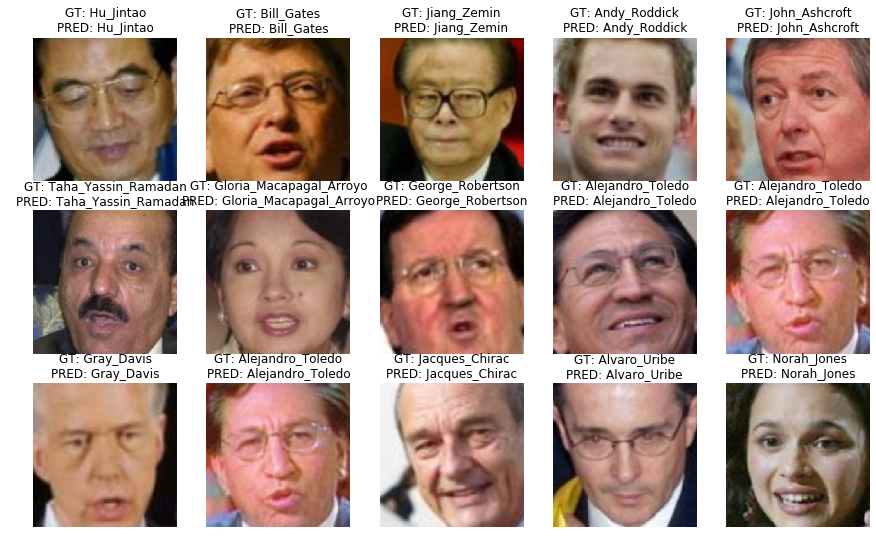

In [32]:
hits_y = {k: 'GT: ' + v + '\nPRED: ' + y_out[k] for k, v in y_test.items() if y_out[k] == v}
hits_x = {k:x_test[k] for k, v in hits_y.items()}
visualize(hits_x, hits_y, function = lambda x:preprocess_imgs(x)[0], n_rows=3)

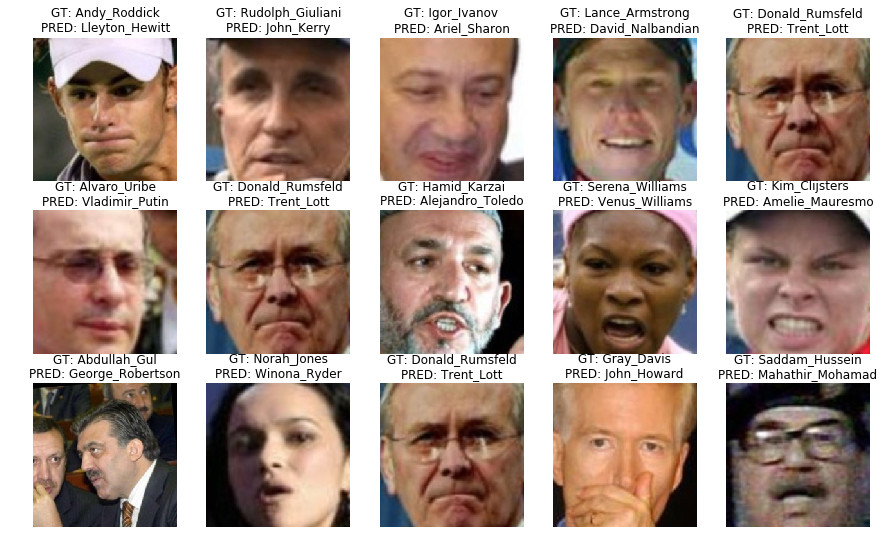

In [33]:
mistakes_y = {k: 'GT: ' + v + '\nPRED: ' + y_out[k] for k, v in y_test.items() if y_out[k] != v}
mistakes_x = {k:x_test[k] for k, v in mistakes_y.items()}
visualize(mistakes_x, mistakes_y, function = lambda x:preprocess_imgs(x)[0], n_rows=3)